In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import earthaccess
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from tools import time_from_attr,open_L2_CLOUD_GPC,plot_hist
from metpy.units import units
import metpy.calc as mpcalc
from metpy.constants import *
import metpy as metpy
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
from tqdm import tqdm

/srv/conda/envs/notebook/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


In [2]:
auth = earthaccess.login(persist=True)

# Plot 1:
OCI vertical histogram of LWP vs CDNC

In [3]:
bbox = (-110,-35,-70,-10)
tspan = ("2025-07-01", "2025-07-31")

results = earthaccess.search_data(
    short_name="PACE_OCI_L3M_CLOUD_NRT",
    bounding_box=bbox,    
    temporal=tspan,
    granule_name="*.DAY.*.0p1deg.*"
)

paths = earthaccess.open(results)

QUEUEING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/31 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/31 [00:00<?, ?it/s]

In [4]:
def ds_slicing(ds):
    datetime = ds.attrs["time_coverage_start"].replace("Z", "")
    time = np.datetime64(datetime, "ns")
    ds = ds.assign_coords(time=[time])
    return(ds.sel(lat=slice(-10,-35),lon=slice(-110,-70)))

In [5]:
dataset = xr.open_mfdataset(
    paths,
    preprocess=ds_slicing
)
dataset

<xarray.Dataset> Size: 558MB
Dimensions:               (time: 31, lat: 250, lon: 400)
Coordinates:
  * lat                   (lat) float32 1kB -10.05 -10.15 ... -34.85 -34.95
  * lon                   (lon) float32 2kB -109.9 -109.8 ... -70.15 -70.05
  * time                  (time) datetime64[ns] 248B 2025-07-01T00:11:24 ... ...
Data variables: (12/45)
    cloud_fraction        (time, lat, lon) float32 12MB dask.array<chunksize=(1, 24, 324), meta=np.ndarray>
    ice_cloud_fraction    (time, lat, lon) float32 12MB dask.array<chunksize=(1, 24, 324), meta=np.ndarray>
    water_cloud_fraction  (time, lat, lon) float32 12MB dask.array<chunksize=(1, 24, 324), meta=np.ndarray>
    ctt                   (time, lat, lon) float32 12MB dask.array<chunksize=(1, 24, 324), meta=np.ndarray>
    ctp                   (time, lat, lon) float32 12MB dask.array<chunksize=(1, 24, 324), meta=np.ndarray>
    cth                   (time, lat, lon) float32 12MB dask.array<chunksize=(1, 24, 324), meta=np.ndarray>
    ...                    ...
    cer_22_water          (time, lat, lon) float32 12MB dask.array<chunksize=(1, 24, 324), meta=np.ndarray>
    cot_22_water          (time, lat, lon) float32 12MB dask.array<chunksize=(1, 24, 324), meta=np.ndarray>
    cwp_22_water          (time, lat, lon) float32 12MB dask.array<chunksize=(1, 24, 324), meta=np.ndarray>
    cer_22_ice            (time, lat, lon) float32 12MB dask.array<chunksize=(1, 24, 324), meta=np.ndarray>
    cot_22_ice            (time, lat, lon) float32 12MB dask.array<chunksize=(1, 24, 324), meta=np.ndarray>
    cwp_22_ice            (time, lat, lon) float32 12MB dask.array<chunksize=(1, 24, 324), meta=np.ndarray>
Attributes: (12/54)
    product_name:                      PACE_OCI.20250701.L3m.DAY.CLOUD.V3_0.0...
    instrument:                        OCI
    title:                             OCI Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from OCI-PACE
    ...                                ...
    keywords:                          
    id:                                L3/PACE_OCI.20250701.L3m.DAY.CLOUD.V3_...
    history:                           l3mapmerge.py -v l3mapmerge_inputs.txt...
    processing_version:                3.0
    identifier_product_doi_authority:  https://dx.doi.org
    identifier_product_doi:            10.5067/PACE/OCI/L3M/CLOUD/3.0

In [6]:
def Nd_from_tau_re(tau,re,Cw=0.0020, fad=0.7, k=0.8,Qe = 2.0):
    """
    tau: cloud optical thickness [unitless]
    re: cloud effective radius [µm]
    fad : adiabaticity of cloud [unitless]
    Cw:   lapse rate of water content [g/m^4]
    k:    disperson const rv^3 = k * re^3
    Qe:  extinction efficiency [unitless]

    """
    C = np.sqrt(5)/(2.0*np.pi*k)
    re_m = re*1e-6 # change unit of re from um to m
    rho  = 1e6 # density of water [g/m^3]
    CDNC = C * np.sqrt(fad*Cw*tau/Qe/rho/(re_m**5)) *1e-6
    return CDNC

In [7]:
Nd = Nd_from_tau_re(dataset.cth_cot,dataset.cer_21)
Nd

<xarray.DataArray (time: 31, lat: 250, lon: 400)> Size: 25MB
dask.array<mul, shape=(31, 250, 400), dtype=float64, chunksize=(1, 226, 324), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 1kB -10.05 -10.15 -10.25 ... -34.75 -34.85 -34.95
  * lon      (lon) float32 2kB -109.9 -109.8 -109.8 ... -70.25 -70.15 -70.05
  * time     (time) datetime64[ns] 248B 2025-07-01T00:11:24 ... 2025-07-30T23...

In [8]:
# precalculate DASK arrays for faster computation/plotting
Nd = Nd.compute()
lwp = dataset.cwp_21.data.compute()

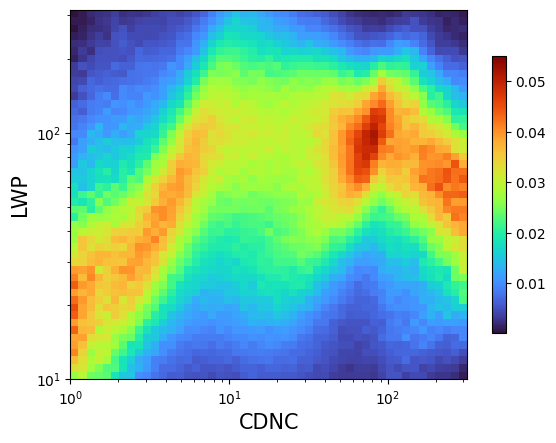

In [9]:
plot_hist(Nd.data.flatten(),lwp.flatten())

# Plot 2:
HARP2 Vertical Histogram of LWP vs CDNC

In [10]:
bbox = (-110,-35,-70,-10)

results = earthaccess.search_data(
    short_name="PACE_HARP2_L2_CLOUD_GPC_NRT",
    bounding_box=bbox,
)
print(len(results))

paths = earthaccess.open(results)

286


QUEUEING TASKS | :   0%|          | 0/286 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/286 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/286 [00:00<?, ?it/s]

In [11]:
er = []
ev = []
cdnc = []
lwp = []
lat = []
lon = []
count = 0
for p in paths:

    try: 
        ds = open_L2_CLOUD_GPC(p,bbox)
        mask = ~np.isnan(ds.cloud_bow_droplet_effective_radius.data.flatten()) & ~np.isnan(ds.cloud_bow_droplet_effective_variance.data.flatten()) & ~np.isnan(ds.cloud_bow_droplet_number_concentration_adiabatic.data.flatten()) & ~np.isnan(ds.cloud_bow_liquid_water_path.data.flatten())        
        er = np.concatenate((er,ds.cloud_bow_droplet_effective_radius.data.flatten()[mask]))
        ev = np.concatenate((ev,ds.cloud_bow_droplet_effective_variance.data.flatten()[mask]))
        cdnc = np.concatenate((cdnc,ds.cloud_bow_droplet_number_concentration_adiabatic.data.flatten()[mask]))
        lwp = np.concatenate((lwp,ds.cloud_bow_liquid_water_path.data.flatten()[mask]))
    #print(ds.date)
        del(ds)
    except:
        print('I had an error', count)
    count += 1

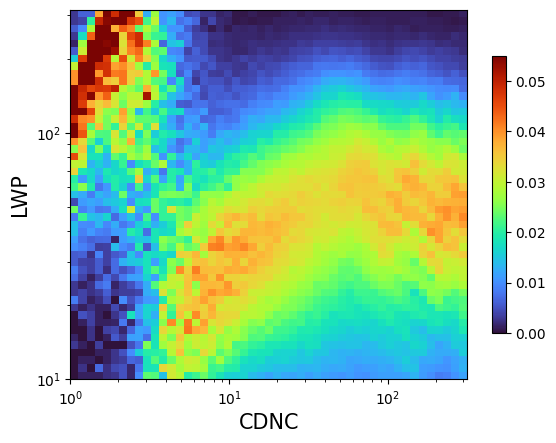

In [12]:
plot_hist(cdnc,lwp)

# Plot 3:
HARP2 comparison of re, ve, $\beta$, water per droplet

In [3]:
results = earthaccess.search_data(
    short_name="PACE_HARP2_L3M_CLOUD_GPC_NRT",
    granule_name="*.DAY.*.0p1deg.*"
)
print(len(results))

paths = earthaccess.open(results)

35


QUEUEING TASKS | :   0%|          | 0/35 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/35 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/35 [00:00<?, ?it/s]

In [4]:
dataset = xr.open_mfdataset(
    paths,
    combine="nested",
    concat_dim="date",
)
dataset

<xarray.Dataset> Size: 6GB
Dimensions:                               (date: 35, lat: 1800, lon: 3600)
Coordinates:
  * lat                                   (lat) float32 7kB 89.95 ... -89.95
  * lon                                   (lon) float32 14kB -179.9 ... 180.0
Dimensions without coordinates: date
Data variables:
    cloud_bow_droplet_effective_radius    (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_droplet_effective_variance  (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_rms                         (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_fit_correlation             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_rft_mode_fraction_0             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_rft_mode_fraction_1             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_liquid_index                    (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
Attributes: (12/54)
    product_name:                      PACE_HARP2.20250701.L3m.DAY.CLOUD_GPC....
    instrument:                        HARP2
    title:                             HARP2 Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from HARP2-PACE
    ...                                ...
    keywords:                          
    id:                                L3/PACE_HARP2.20250701.L3m.DAY.CLOUD_G...
    history:                           l3mapmerge.py -v l3mapmerge_inputs.txt...
    processing_version:                3.0
    identifier_product_doi_authority:  https://dx.doi.org
    identifier_product_doi:            10.5067/PACE/HARP2/L3M/CLOUD/3.0

In [5]:
def calc_DE_params(er,ev):
    '''
    Calculate the beta, LN, b parameters
    from Wang et al. 2025
    '''
    ev_u = ev * units('')
    er_u = er * units('um')
    beta = ((1-ev_u)*(1-2*ev_u))**(-1/3)
    A = 4/3 * np.pi * density_water
    LN = A * (1-ev_u) * (1-2*ev_u) * er_u**3
    return(beta,LN.metpy.convert_units('g'))

In [ ]:
ev = dataset.cloud_bow_droplet_effective_variance.compute()

In [10]:
ev_flat = ev.data.flatten()
ev_flat[ev_flat>0.35]=np.nan
ev_cut = ev_flat.reshape(ev.data.shape)

In [14]:
print(ev_cut.shape,np.nanmax(ev_cut))

(35, 1800, 3600) 0.35


In [16]:
dataset = dataset.assign(ev_cut = (['date','lat','lon'],ev_cut))
dataset

<xarray.Dataset> Size: 9GB
Dimensions:                               (date: 35, lat: 1800, lon: 3600)
Coordinates:
  * lat                                   (lat) float32 7kB 89.95 ... -89.95
  * lon                                   (lon) float32 14kB -179.9 ... 180.0
Dimensions without coordinates: date
Data variables:
    cloud_bow_droplet_effective_radius    (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_droplet_effective_variance  (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_rms                         (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_fit_correlation             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_rft_mode_fraction_0             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_rft_mode_fraction_1             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_liquid_index                    (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    beta                                  (date, lat, lon) float32 907MB <Qua...
    LN                                    (date, lat, lon) float32 907MB <Qua...
    ev_cut                                (date, lat, lon) float32 907MB 0.24...
Attributes: (12/54)
    product_name:                      PACE_HARP2.20250701.L3m.DAY.CLOUD_GPC....
    instrument:                        HARP2
    title:                             HARP2 Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from HARP2-PACE
    ...                                ...
    keywords:                          
    id:                                L3/PACE_HARP2.20250701.L3m.DAY.CLOUD_G...
    history:                           l3mapmerge.py -v l3mapmerge_inputs.txt...
    processing_version:                3.0
    identifier_product_doi_authority:  https://dx.doi.org
    identifier_product_doi:            10.5067/PACE/HARP2/L3M/CLOUD/3.0

In [19]:
dataset=dataset.assign(beta = (['date','lat','lon'],calc_DE_params(dataset.cloud_bow_droplet_effective_radius,dataset.ev_cut)[0].data))
dataset=dataset.assign(LN = (['date','lat','lon'],calc_DE_params(dataset.cloud_bow_droplet_effective_radius,dataset.ev_cut)[1].data))
dataset

<xarray.Dataset> Size: 9GB
Dimensions:                               (date: 35, lat: 1800, lon: 3600)
Coordinates:
  * lat                                   (lat) float32 7kB 89.95 ... -89.95
  * lon                                   (lon) float32 14kB -179.9 ... 180.0
Dimensions without coordinates: date
Data variables:
    cloud_bow_droplet_effective_radius    (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_droplet_effective_variance  (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_rms                         (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_bow_fit_correlation             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_rft_mode_fraction_0             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_rft_mode_fraction_1             (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    cloud_liquid_index                    (date, lat, lon) float32 907MB dask.array<chunksize=(1, 512, 1024), meta=np.ndarray>
    beta                                  (date, lat, lon) float32 907MB <Qua...
    LN                                    (date, lat, lon) float32 907MB <Qua...
    ev_cut                                (date, lat, lon) float32 907MB 0.24...
Attributes: (12/54)
    product_name:                      PACE_HARP2.20250701.L3m.DAY.CLOUD_GPC....
    instrument:                        HARP2
    title:                             HARP2 Level-3 Standard Mapped Image
    project:                           Ocean Biology Processing Group (NASA/G...
    platform:                          PACE
    source:                            satellite observations from HARP2-PACE
    ...                                ...
    keywords:                          
    id:                                L3/PACE_HARP2.20250701.L3m.DAY.CLOUD_G...
    history:                           l3mapmerge.py -v l3mapmerge_inputs.txt...
    processing_version:                3.0
    identifier_product_doi_authority:  https://dx.doi.org
    identifier_product_doi:            10.5067/PACE/HARP2/L3M/CLOUD/3.0

In [20]:
ds_mean = dataset.mean(dim='date')

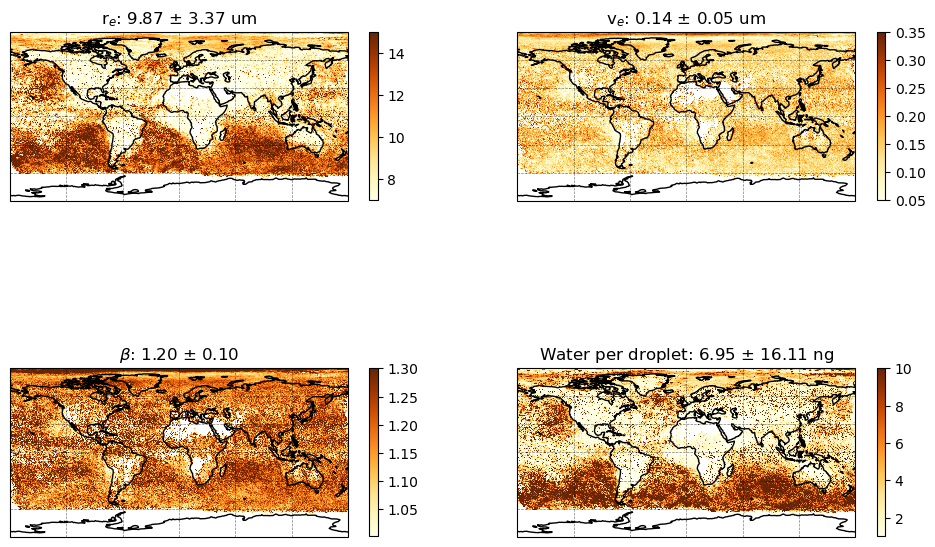

In [28]:

cm = 'YlOrBr'


fig = plt.figure(figsize=[12,8])

ax = fig.add_subplot(2, 2, 1, projection=ccrs.PlateCarree())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.cloud_bow_droplet_effective_radius,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap=cm,vmin=7,vmax=15)
plt.colorbar(im,shrink=0.6,ax=ax)
ax.set_aspect("equal")
ax.coastlines()

ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title(r'r$_e$: {mean:.2f} $\pm$ {std:.2f} um'.format(mean = np.nanmean(ds_mean.cloud_bow_droplet_effective_radius),std = np.nanstd(ds_mean.cloud_bow_droplet_effective_radius)))



ax = fig.add_subplot(2, 2, 2, projection=ccrs.PlateCarree())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.ev_cut,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap=cm,vmin=0.05,vmax=0.35)#,norm=LogNorm(vmin=0.15,vmax=0.5))
plt.colorbar(im,shrink=0.6,ax=ax)
ax.set_aspect("equal")
ax.coastlines()

ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title(r'v$_e$: {mean:.2f} $\pm$ {std:.2f} um'.format(mean = np.nanmean(ds_mean.ev_cut),std = np.nanstd(ds_mean.ev_cut)))




ax = fig.add_subplot(2, 2, 3, projection=ccrs.PlateCarree())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.beta,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap=cm,vmax = 1.3)
plt.colorbar(im,shrink=0.6,ax=ax)
ax.set_aspect("equal")
ax.coastlines()

ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title(r'$\beta$: {mean:.2f} $\pm$ {std:.2f}'.format(mean = np.nanmean(ds_mean.beta),std = np.nanstd(ds_mean.beta)))


ax = fig.add_subplot(2, 2, 4, projection=ccrs.PlateCarree())

im = ax.pcolormesh(ds_mean.lon,ds_mean.lat,ds_mean.LN.metpy.convert_units('ng'),
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap=cm,vmin=1,vmax=10)#norm=LogNorm(vmin=1e-9,vmax=1e-7))
plt.colorbar(im,shrink=0.6,ax=ax)
ax.set_aspect("equal")
ax.coastlines()

ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title(r'Water per droplet: {mean:.2f} $\pm$ {std:.2f} ng'.format(mean = np.nanmean(ds_mean.LN.metpy.convert_units('ng')),std = np.nanstd(ds_mean.LN.metpy.convert_units('ng'))))


plt.show()

# Plot 3b:
HARP2 comparison of b parameter, number effect (DO$_{Nd}$), LWP adjustment effect (DO$_{LWP}$)

In [22]:
lat_floor = np.floor(ds_mean.lat)
lon_floor = np.floor(ds_mean.lon)
ds_mean = ds_mean.assign(lat_floor=(['lat'],lat_floor.data))
ds_mean = ds_mean.assign(lon_floor=(['lon'],lon_floor.data))

ds_mean_floor = ds_mean.set_index(lat='lat_floor',lon='lon_floor')
ds_LN = ds_mean_floor.LN.compute()
ds_beta = ds_mean_floor.beta.compute()
ds_lnbeta = xr.merge((ds_LN,ds_beta))
ds_lnbeta

Magnitude,[[3.3235221241767476e-09 3.3235221241767476e-09 3.3235221241767476e-09 ... 7.487557240892784e-09 7.487557240892784e-09 7.487557240892784e-09] [2.252377839795372e-09 2.252377839795372e-09 2.252377839795372e-09 ... 2.155751577248566e-09 2.155751577248566e-09 2.155751577248566e-09] [1.0102446657000996e-09 1.0102446657000996e-09 1.0102446657000996e-09 ... 1.3820964372968092e-09 1.3820964372968092e-09 1.3820964372968092e-09] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]]
Units,gram
Magnitude,[[1.4082313776016235 1.4082313776016235 1.4082313776016235 ... 1.3745486736297607 1.3745486736297607 1.3745486736297607] [1.4606276750564575 1.4606276750564575 1.4606276750564575 ... 1.4182015657424927 1.4182015657424927 1.4182015657424927] [1.4799391031265259 1.4799391031265259 1.4799391031265259 ... 1.45720374584198 1.45720374584198 1.45720374584198] ... [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan] [nan nan nan ... nan nan nan]]
Units,dimensionless


In [23]:
def fit(LN,a,b):
    return(a*LN**b)

def find_b(LN,beta):
        #print(ds.lat)
    LN = LN.flatten()
    beta = beta.flatten()
    mask = ~np.isnan(LN)&~np.isnan(beta)
    if mask.sum()>1:
        try:
            popt,pcov = curve_fit(fit,LN[mask],beta[mask])
            #print(popt[0])
            out_opt = popt[1]
            out_p = np.sqrt(np.diag(pcov))[1]
            #out_p = pcov
        except:
            out_opt=np.nan
            out_p = np.nan
            #print('fit failure')
    else:
        #print('no values')
        out_opt= np.nan
        out_p = np.nan
    return(out_opt,out_p)

In [24]:
lats = np.arange(-90,90,1)
lons = np.arange(-180,180,1)
bs = np.zeros((180,360))
ps = np.zeros((180,360))
i = 0
j = 0

for lat in tqdm(lats):
    for lon in lons:
        ds = ds_lnbeta.sel(lat=lat).sel(lon=lon)
        LN = ds.LN.data.magnitude
        beta=ds.beta.data.magnitude
        b,p=find_b(LN,beta)
        bs[lat+90,lon+180] = b
        #print(p)
        ps[lat+90,lon+180] = p

/tmp/ipykernel_6827/715718497.py:2: RuntimeWarning: overflow encountered in power
  return(a*LN**b)
/tmp/ipykernel_6827/715718497.py:11: OptimizeWarning: Covariance of the parameters could not be estimated
  popt,pcov = curve_fit(fit,LN[mask],beta[mask])
100%|██████████| 180/180 [02:21<00:00,  1.28it/s]


In [25]:
bs_good = bs[:,:]
bs_good[ps>0.05]=np.nan

DOND = -300*bs_good
DOLWP = 300*bs_good/5

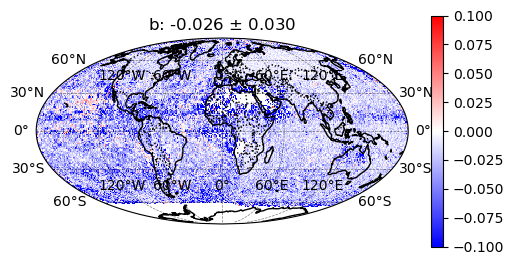

In [29]:
fig = plt.figure(figsize=[6,5])
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())

im = ax.pcolormesh(lons,lats,bs_good,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap='bwr',vmin=-0.1,vmax=0.1)
fig.colorbar(im,shrink=0.6)
ax.set_aspect("equal")
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
#ax.set_title('b:' + str(np.nanmean(bs))[:7]+r'$\pm$'+str(np.nanstd(bs))[:6])
ax.set_title(r'b: {:.3f} $\pm$ {:.3f}'.format(np.nanmean(bs_good),np.nanstd(bs_good)))
plt.show()

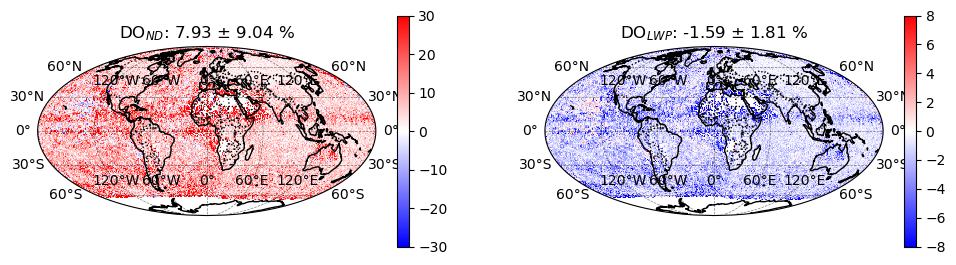

In [30]:
fig = plt.figure(figsize=[12,10])
ax = fig.add_subplot(1, 2, 1, projection=ccrs.Mollweide())

im = ax.pcolormesh(lons,lats,DOND,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap='bwr',vmin=-30,vmax=30)
fig.colorbar(im,shrink=0.3)
ax.set_aspect("equal")
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title(r'DO$_{{ND}}$: {mean:.2f} $\pm$ {std:.2f} %'.format(mean=np.nanmean(DOND),std=np.nanstd(DOND)))


ax = fig.add_subplot(1, 2, 2, projection=ccrs.Mollweide())

im = ax.pcolormesh(lons,lats,DOLWP,
        shading="nearest", rasterized=True, transform=ccrs.PlateCarree(),cmap='bwr',vmin=-8,vmax=8)
fig.colorbar(im,shrink=0.3)
ax.set_aspect("equal")
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
           linewidth=0.5, color='black', alpha=0.5, linestyle='--')
ax.set_title(r'DO$_{{LWP}}$: {mean:.2f} $\pm$ {std:.2f} %'.format(mean=np.nanmean(DOLWP),std=np.nanstd(DOLWP)))


plt.show()

# Plot 4:
Cloudbow/RFT comparison of histogram of liquid water per droplet and beta

In [4]:
bbox = (-110,-35,-70,-10)

results = earthaccess.search_data(
    short_name="PACE_HARP2_L2_CLOUD_GPC_NRT",
    bounding_box=bbox,
)
print(len(results))

paths = earthaccess.open(results)

286


QUEUEING TASKS | :   0%|          | 0/286 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/286 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/286 [00:00<?, ?it/s]

In [5]:
def open_L2_CLOUD_GPC(path,bounding_box=(-170,-60,-120,-50)):
    """
    Args:
        path: a path to a dataset corresponding to one Level-2 granule
        bounding_box: optional argument of bounding box for region (defaults to Southern Ocean)
    Returns:
        the dataset restricted to the bounding_box region, with specific variables, and with the datetime added as time coord
    """
    dt = xr.open_datatree(path)
    ds = xr.merge(dt.to_dict().values())
    ds = time_from_attr(ds)
    ds = ds.set_coords(('latitude','longitude'))
    ds = ds[['cloud_bow_droplet_effective_radius',
             'cloud_bow_droplet_effective_variance',
             'cloud_rft_droplet_effective_radius_mode_0',
             'cloud_rft_droplet_effective_variance_mode_0',
             'cloud_rft_mode_fraction_0',
             'cloud_bow_droplet_number_concentration_adiabatic',
             'cloud_bow_liquid_water_path']]
    W,S,E,N = bounding_box
    lat_mask = np.logical_and(ds.latitude<=N,ds.latitude>=S)
    lon_mask = np.logical_and(ds.longitude<=E,ds.longitude>=W)
    mask = np.logical_and(lat_mask,lon_mask)
    ds = ds.where(mask,drop=True)
    return(ds)

In [14]:
er = []
ev = []
er_rft = []
ev_rft = []
mf = []
cdnc = []
lwp = []
lat = []
lon = []
count = 0
for p in paths:

    try: 
        ds = open_L2_CLOUD_GPC(p,bbox)
        #mask = ~np.isnan(ds.cloud_rft_mode_fraction_0.data.flatten()) & ~np.isnan(ds.cloud_bow_droplet_effective_radius.data.flatten()) & ~np.isnan(ds.cloud_bow_droplet_effective_variance.data.flatten()) & ~np.isnan(ds.cloud_bow_droplet_number_concentration_adiabatic.data.flatten()) & ~np.isnan(ds.cloud_bow_liquid_water_path.data.flatten()) & ~np.isnan(ds.cloud_rft_droplet_effective_variance_mode_0.data.flatten()) & ~np.isnan(ds.cloud_bow_droplet_effective_radius.data.flatten())     
        er = np.concatenate((er,ds.cloud_bow_droplet_effective_radius.data.flatten()))
        ev = np.concatenate((ev,ds.cloud_bow_droplet_effective_variance.data.flatten()))
        er_rft = np.concatenate((er_rft,ds.cloud_rft_droplet_effective_radius_mode_0.data.flatten()))
        ev_rft = np.concatenate((ev_rft,ds.cloud_rft_droplet_effective_variance_mode_0.data.flatten()))
        mf = np.concatenate((mf,ds.cloud_rft_mode_fraction_0.data.flatten()))
        cdnc = np.concatenate((cdnc,ds.cloud_bow_droplet_number_concentration_adiabatic.data.flatten()))
        lwp = np.concatenate((lwp,ds.cloud_bow_liquid_water_path.data.flatten()))
    #print(ds.date)
        del(ds)
    except:
        print('I had an error', count)
    count += 1

In [7]:
def calc_DE_params(er,ev):
    '''
    Calculate the beta, LN, b parameters
    from Wang et al. 2025
    '''
    ev_u = ev * units('')
    er_u = er * units('um')
    beta = ((1-ev_u)*(1-2*ev_u))**(-1/3)
    A = 4/3 * np.pi * density_water
    LN = A * (1-ev_u) * (1-2*ev_u) * er_u**3
    return(beta.magnitude,LN.to('g').magnitude)

In [12]:
beta,LN = calc_DE_params(er_rft,ev_rft)

/srv/conda/envs/notebook/lib/python3.11/site-packages/pint/facets/plain/quantity.py:1271: RuntimeWarning: invalid value encountered in power
  magnitude = new_self._magnitude**exponent


In [18]:
mask = ~np.isnan(beta) & ~np.isnan(LN) & (mf>0.75)
popt,pcov = curve_fit(fit,LN[mask],beta[mask])

popt

/tmp/ipykernel_968/715718497.py:2: RuntimeWarning: overflow encountered in power
  return(a*LN**b)


array([ 0.96925923, -0.00373482])

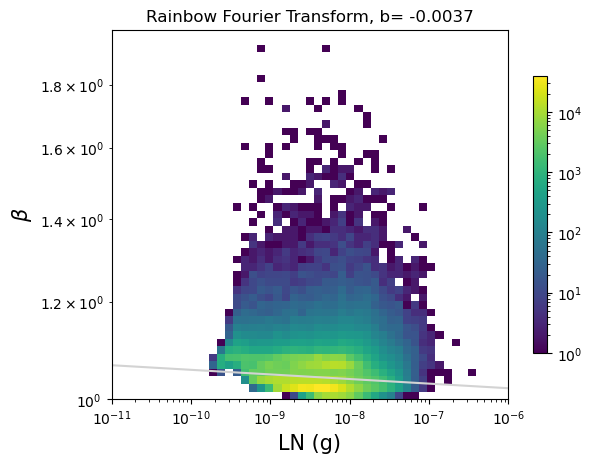

In [19]:
fig,ax = plt.subplots()

xbins = np.logspace(-11,-6,50) # <- make a range from 10**xmin to 10**xmax
#print(xbins)
ybins = np.logspace(0,0.3,50) # <- make a range from 10**ymin to 10**ymax
#print(xbins,ybins)
h,xedge,yedge,im = ax.hist2d(LN[mask],beta[mask],bins=(xbins,ybins),norm=LogNorm())

fig.colorbar(im,shrink=0.75)
ax.set_ylabel(r'$\beta$',fontsize=15)
ax.set_xlabel('LN (g)',fontsize=15)
ax.set_xscale('log')
ax.set_yscale('log')

x = np.logspace(-11,-6,10)
y = fit(x,popt[0],popt[1])

ax.plot(x,y,c='lightgray')
ax.set_title('Rainbow Fourier Transform, b= {:.4f}'.format(popt[1]))
plt.show()

In [45]:
print(np.min(er[mask]),np.max(er[mask]))
print(np.min(ev[mask]),np.max(ev[mask]))

3.0 53.368961334228516
0.0015036390395835042 0.49751242995262146


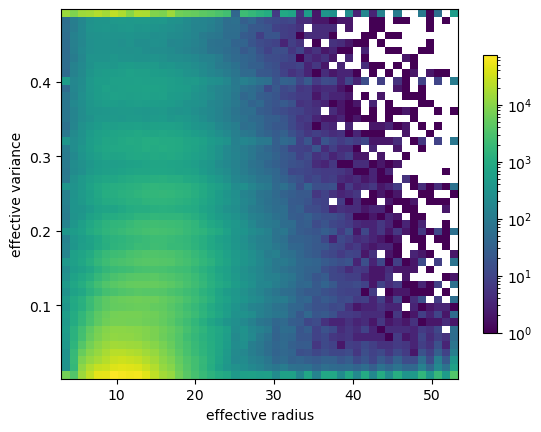

In [43]:
mask = ~np.isnan(er) & ~np.isnan(ev)

fig,ax = plt.subplots()
xbin = np.linspace(np.min(er[mask]),np.max(er[mask]),50)
ybin = np.linspace(np.min(ev[mask]),np.max(ev[mask]),50)
h,xedge,yedge,im=ax.hist2d(er[mask],ev[mask],bins=(xbin,ybin),norm=LogNorm())
fig.colorbar(im,shrink=0.75)

ax.set_xlabel('effective radius')
ax.set_ylabel('effective variance')

plt.show()

In [15]:
er[er==np.nanmin(er)]=np.nan
er[er==np.nanmax(er)]=np.nan
ev[ev==np.nanmin(ev)]=np.nan
ev[ev>=0.35]=np.nan

mask = ~np.isnan(er) & ~ np.isnan(ev)

array([], dtype=float64)

In [16]:
beta,LN = calc_DE_params(er[mask],ev[mask])

mask = ~np.isnan(beta) & ~np.isnan(LN)
popt,pcov = curve_fit(fit,LN[mask],beta)

popt

/tmp/ipykernel_6673/715718497.py:2: RuntimeWarning: overflow encountered in power
  return(a*LN**b)


array([ 0.89359892, -0.0111074 ])

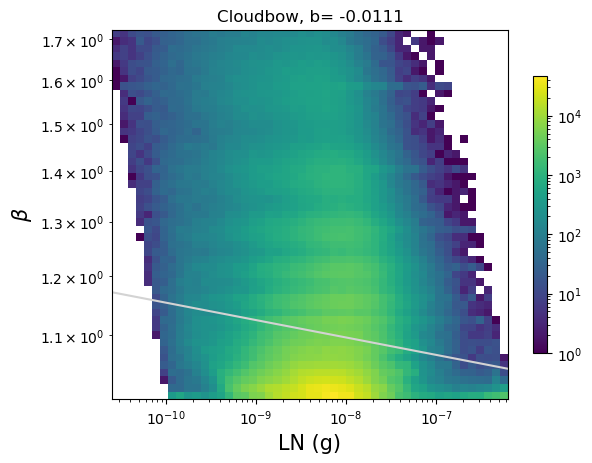

In [17]:
fig,ax = plt.subplots()

xbins = np.logspace(np.log10(np.min(LN)),np.log10(np.max(LN)),50) # <- make a range from 10**xmin to 10**xmax
#print(xbins)
ybins = np.logspace(np.log10(np.min(beta)),np.log10(np.max(beta)),50) # <- make a range from 10**ymin to 10**ymax
#print(xbins,ybins)
h,xedge,yedge,im = ax.hist2d(LN,beta,bins=(xbins,ybins),norm=LogNorm())

fig.colorbar(im,shrink=0.75)
ax.set_ylabel(r'$\beta$',fontsize=15)
ax.set_xlabel('LN (g)',fontsize=15)
ax.set_xscale('log')
ax.set_yscale('log')

x = np.logspace(-13,-6,10)
y = fit(x,popt[0],popt[1])

ax.plot(x,y,c='lightgray')
ax.set_title('Cloudbow, b= {:.4f}'.format(popt[1]))
plt.show()